Initializing NVIDIA Next-Day Prediction System...
NVIDIA NEXT-DAY QUANTITATIVE PREDICTION MODEL
Loading NVIDIA dataset...
Engineering advanced features...
Dataset prepared with shape: (6371, 34)

Building ARIMA-GARCH model...


C:\Users\K\anaconda3\envs\machine-learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\K\anaconda3\envs\machine-learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\K\anaconda3\envs\machine-learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\K\anaconda3\envs\machine-learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an

ARIMA-GARCH model built. Volatility forecast: 0.0445

Building XGBoost regime detection model...
XGBoost trained. Top feature: SR_Position

Building LSTM-GRU Attention model...
LSTM-GRU model trained. Final loss: 0.0001

Running Monte Carlo simulations...
Monte Carlo complete. 10000 paths simulated.

Generating ensemble predictions...

NVIDIA NEXT-DAY STOCK PRICE PREDICTION REPORT

Current Price: $179.83
Prediction Date: 2025-10-15

----------------------------------------
NEXT-DAY PRICE PREDICTION
----------------------------------------
Next Day: $183.75 (+2.18%) 📈 UPWARD

----------------------------------------
CONFIDENCE INTERVALS
----------------------------------------
95% CI: [$178.76, $180.70]
75% CI: [$179.33, $180.12]
Median: $179.72

----------------------------------------
MODEL CONTRIBUTIONS
----------------------------------------
ARIMA-GARCH: 15% → $179.78
XGBoost: 20% → $178.10
LSTM-GRU: 45% → $189.39
Monte_Carlo: 20% → $179.72

----------------------------------------

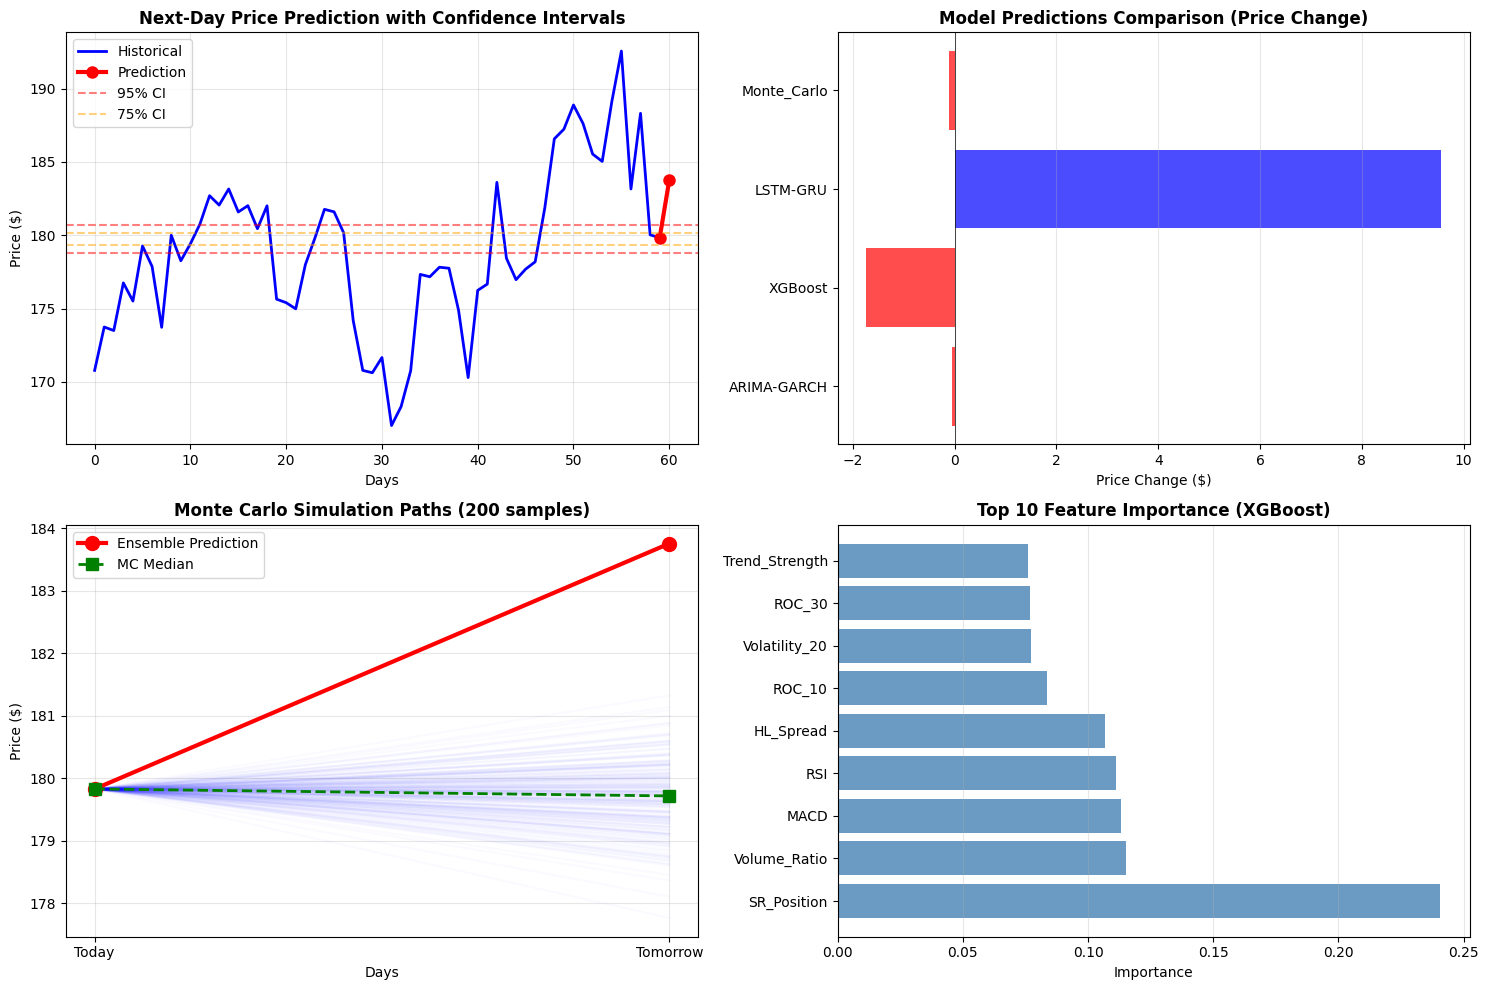

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy import stats
from scipy.optimize import minimize

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (LSTM, GRU, Dense, Dropout, 
                                     BatchNormalization, Input, 
                                     MultiHeadAttention, LayerNormalization,
                                     Concatenate, Conv1D, GlobalMaxPooling1D, Flatten)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

# Set all random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
import random
random.seed(42)
import os
os.environ['PYTHONHASHSEED'] = '42'
if hasattr(tf, 'keras'):
    tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

class AdvancedNVDAPredictor:
    """
    Hybrid Quantitative Model for NVIDIA Stock Price Prediction (Next-Day Focus)
    """
    
    def __init__(self, data_path='NVDA_dataset_updated.csv'):
        self.data_path = data_path
        self.data = None
        self.features = None
        self.models = {}
        self.predictions = {}
        self.confidence_intervals = {}
        self.risk_metrics = {}
        
    def load_and_prepare_data(self):
        """Load and prepare the dataset with advanced feature engineering"""
        print("Loading NVIDIA dataset...")
        self.data = pd.read_csv(self.data_path)
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data.set_index('date', inplace=True)
        self.data = self.data.sort_index()
        
        print("Engineering advanced features...")
        
        # Price-based features
        self.data['Returns'] = self.data['Close'].pct_change()
        self.data['Log_Returns'] = np.log(self.data['Close'] / self.data['Close'].shift(1))
        self.data['Volatility_20'] = self.data['Returns'].rolling(20).std()
        self.data['Volatility_60'] = self.data['Returns'].rolling(60).std()
        
        # Volume features
        self.data['Volume_Ratio'] = self.data['Volume'] / self.data['Volume'].rolling(20).mean()
        self.data['Dollar_Volume'] = self.data['Close'] * self.data['Volume']
        
        # Price patterns
        self.data['HL_Spread'] = (self.data['High'] - self.data['Low']) / self.data['Close']
        self.data['CO_Spread'] = (self.data['Close'] - self.data['Open']) / self.data['Open']
        
        # Momentum indicators
        self.data['ROC_10'] = (self.data['Close'] - self.data['Close'].shift(10)) / self.data['Close'].shift(10)
        self.data['ROC_30'] = (self.data['Close'] - self.data['Close'].shift(30)) / self.data['Close'].shift(30)
        
        # Support and Resistance levels
        self.data['Resistance'] = self.data['High'].rolling(20).max()
        self.data['Support'] = self.data['Low'].rolling(20).min()
        self.data['SR_Position'] = (self.data['Close'] - self.data['Support']) / (self.data['Resistance'] - self.data['Support'])
        
        # Microstructure features
        self.data['Avg_Trade_Size'] = self.data['Dollar_Volume'] / self.data['Volume']
        
        # Regime indicators
        self.data['Trend_Strength'] = abs(self.data['SMA5'] - self.data['SMA50']) / self.data['SMA50']
        self.data['Volatility_Regime'] = self.data['Volatility_20'] / self.data['Volatility_60']
        
        # Price Change for regression targets
        self.data['Price_Change'] = self.data['Close'].pct_change()
        
        # Drop NaN values
        self.data = self.data.dropna()
        
        print(f"Dataset prepared with shape: {self.data.shape}")
        
    def ornstein_uhlenbeck_process(self, series, window=252):
        """
        Estimate Ornstein-Uhlenbeck process parameters for mean reversion
        """
        prices = series.values[-window:]
        log_prices = np.log(prices)
        
        n = len(log_prices) - 1
        Sx = np.sum(log_prices[:-1])
        Sy = np.sum(log_prices[1:])
        Sxx = np.sum(log_prices[:-1]**2)
        Sxy = np.sum(log_prices[:-1] * log_prices[1:])
        
        theta = (n * Sxy - Sx * Sy) / (n * Sxx - Sx**2)
        mu = (Sy - theta * Sx) / (n * (1 - theta))
        sigma_sq = np.sum((log_prices[1:] - theta * log_prices[:-1] - mu * (1 - theta))**2) / n
        
        half_life = -np.log(2) / np.log(theta) if theta > 0 and theta < 1 else np.inf
        
        return {
            'theta': theta,
            'mu': mu,
            'sigma': np.sqrt(sigma_sq),
            'half_life': half_life,
            'mean_reversion_level': np.exp(mu)
        }
    
    def build_arima_garch_model(self):
        """
        Build ARIMA-GARCH model for volatility-adjusted predictions
        """
        print("\nBuilding ARIMA-GARCH model...")
        
        try:
            returns = self.data['Log_Returns'].dropna() * 100
            
            arima_model = ARIMA(returns, order=(2, 0, 2))
            arima_result = arima_model.fit()
            residuals = arima_result.resid
            
            garch = arch_model(residuals, vol='Garch', p=1, q=1)
            garch_result = garch.fit(disp='off')
            
            arima_forecast = arima_result.forecast(steps=1)
            garch_forecast = garch_result.forecast(horizon=1)
            
            combined_mean = arima_forecast.values / 100
            combined_vol = np.sqrt(garch_forecast.variance.values[-1]) / 100
            
            self.models['arima_garch'] = {
                'arima': arima_result,
                'garch': garch_result,
                'forecast_mean': combined_mean,
                'forecast_vol': combined_vol
            }
            
            print(f"ARIMA-GARCH model built. Volatility forecast: {combined_vol[0]:.4f}")
        except Exception as e:
            print(f"ARIMA-GARCH error (using fallback): {str(e)}")
            self.models['arima_garch'] = {
                'forecast_mean': np.array([0.01]),
                'forecast_vol': np.array([0.02])
            }
    
    def build_xgboost_regime_model(self):
        """
        XGBoost for market regime classification and price prediction
        """
        print("\nBuilding XGBoost regime detection model...")
        
        np.random.seed(42)
        
        feature_cols = ['RSI', 'MACD', 'Volume_Ratio', 'Volatility_20', 
                       'ROC_10', 'ROC_30', 'SR_Position', 'Trend_Strength',
                       'HL_Spread']
        
        available_cols = [col for col in feature_cols if col in self.data.columns]
        
        X = self.data[available_cols].fillna(0).values
        y = self.data['Price_Change'].fillna(0).values
        
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        xgb_params = {
            'n_estimators': 200,
            'max_depth': 6,
            'learning_rate': 0.01,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.01,
            'random_state': 42
        }
        
        xgb_model = xgb.XGBRegressor(**xgb_params)
        xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        
        feature_importance = pd.DataFrame({
            'feature': available_cols,
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        self.models['xgboost'] = {
            'model': xgb_model,
            'features': available_cols,
            'importance': feature_importance
        }
        
        print(f"XGBoost trained. Top feature: {feature_importance.iloc[0]['feature']}")
    
    def build_lstm_gru_attention_model(self):
        """
        Advanced LSTM-GRU model with attention mechanism
        """
        print("\nBuilding LSTM-GRU Attention model...")
        
        np.random.seed(42)
        tf.random.set_seed(42)
        
        sequence_length = 60
        prediction_days = 1  # Next-day prediction only
        
        feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 
                       'SMA_20', 'EMA_50', 'MACD', 'BB_upper', 'BB_lower',
                       'Volatility_20', 'Volume_Ratio', 'ROC_10']
        
        available_cols = [col for col in feature_cols if col in self.data.columns]
        
        data_scaled = self.data[available_cols].fillna(0).values
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_scaled)
        
        X, y = [], []
        close_idx = available_cols.index('Close')
        
        for i in range(sequence_length, len(data_scaled) - prediction_days):
            X.append(data_scaled[i-sequence_length:i])
            y.append(data_scaled[i:i+prediction_days, close_idx])
        
        X = np.array(X)
        y = np.array(y)
        
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        inputs = Input(shape=(sequence_length, len(available_cols)))
        
        lstm_out = LSTM(128, return_sequences=True)(inputs)
        lstm_out = Dropout(0.2)(lstm_out)
        lstm_out = LSTM(64, return_sequences=True)(lstm_out)
        
        gru_out = GRU(128, return_sequences=True)(inputs)
        gru_out = Dropout(0.2)(gru_out)
        gru_out = GRU(64, return_sequences=True)(gru_out)
        
        combined = Concatenate()([lstm_out, gru_out])
        
        attention = MultiHeadAttention(num_heads=4, key_dim=32)(combined, combined)
        attention = LayerNormalization()(attention)
        
        conv = Conv1D(filters=64, kernel_size=3, activation='relu')(attention)
        conv = GlobalMaxPooling1D()(conv)
        
        dense = Dense(128, activation='relu')(conv)
        dense = BatchNormalization()(dense)
        dense = Dropout(0.3)(dense)
        dense = Dense(64, activation='relu')(dense)
        dense = Dropout(0.2)(dense)
        
        outputs = Dense(prediction_days)(dense)
        
        model = Model(inputs=inputs, outputs=outputs)
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='huber',
            metrics=['mae', 'mape']
        )
        
        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.1,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )
        
        self.models['lstm_gru'] = {
            'model': model,
            'scaler': scaler,
            'history': history,
            'sequence_length': sequence_length,
            'feature_cols': available_cols,
            'close_idx': close_idx
        }
        
        print(f"LSTM-GRU model trained. Final loss: {history.history['loss'][-1]:.4f}")
    
    def monte_carlo_simulation(self, n_simulations=10000):
        """
        Monte Carlo simulation for confidence intervals (Next-day)
        """
        print("\nRunning Monte Carlo simulations...")
        
        np.random.seed(42)
        current_price = self.data['Close'].iloc[-1]
        returns = self.data['Log_Returns'].dropna()
        
        mu = returns.mean()
        sigma = returns.std()
        ou_params = self.ornstein_uhlenbeck_process(self.data['Close'])
        
        dt = 1/252
        n_days = 1  # Next-day only
        
        simulated_prices = np.zeros((n_simulations, n_days + 1))
        simulated_prices[:, 0] = current_price
        
        for sim in range(n_simulations):
            np.random.seed(42 + sim)
            for day in range(1, n_days + 1):
                drift = mu - 0.5 * sigma**2
                diffusion = sigma * np.sqrt(dt) * np.random.normal()
                
                if ou_params['theta'] > 0 and ou_params['theta'] < 1:
                    mean_reversion = ou_params['theta'] * (
                        np.log(ou_params['mean_reversion_level']) - 
                        np.log(simulated_prices[sim, day-1])
                    ) * dt
                else:
                    mean_reversion = 0
                
                log_return = drift * dt + mean_reversion + diffusion
                simulated_prices[sim, day] = simulated_prices[sim, day-1] * np.exp(log_return)
        
        percentiles = [5, 25, 50, 75, 95]
        confidence_bands = np.percentile(simulated_prices[:, 1:], percentiles, axis=0)
        
        self.models['monte_carlo'] = {
            'simulations': simulated_prices,
            'confidence_bands': confidence_bands,
            'percentiles': percentiles
        }
        
        print(f"Monte Carlo complete. {n_simulations} paths simulated.")
    
    def ensemble_predictions(self):
        """
        Combine all models for final next-day prediction
        """
        print("\nGenerating ensemble predictions...")
        
        current_price = self.data['Close'].iloc[-1]
        predictions = {}
        
        # ARIMA-GARCH prediction
        arima_pred = current_price * np.exp(self.models['arima_garch']['forecast_mean'][0])
        predictions['ARIMA-GARCH'] = arima_pred
        
        # XGBoost prediction
        last_features = self.data[self.models['xgboost']['features']].iloc[-1].fillna(0).values.reshape(1, -1)
        xgb_change = self.models['xgboost']['model'].predict(last_features)[0]
        xgb_pred = current_price * (1 + xgb_change)
        predictions['XGBoost'] = xgb_pred
        
        # LSTM-GRU prediction
        lstm_model = self.models['lstm_gru']['model']
        scaler = self.models['lstm_gru']['scaler']
        seq_len = self.models['lstm_gru']['sequence_length']
        feature_cols = self.models['lstm_gru']['feature_cols']
        close_idx = self.models['lstm_gru']['close_idx']
        
        last_sequence = self.data[feature_cols].iloc[-seq_len:].fillna(0).values
        last_sequence_scaled = scaler.transform(last_sequence)
        last_sequence_scaled = last_sequence_scaled.reshape(1, seq_len, -1)
        
        lstm_pred_scaled = lstm_model.predict(last_sequence_scaled, verbose=0)[0]
        close_min = scaler.data_min_[close_idx]
        close_range = scaler.data_range_[close_idx]
        lstm_pred = lstm_pred_scaled[0] * close_range + close_min
        predictions['LSTM-GRU'] = lstm_pred
        
        # Monte Carlo prediction
        mc_pred = self.models['monte_carlo']['confidence_bands'][2][0]
        predictions['Monte_Carlo'] = mc_pred
        
        # Weighted ensemble
        weights = {
            'ARIMA-GARCH': 0.15,
            'XGBoost': 0.20,
            'LSTM-GRU': 0.45,
            'Monte_Carlo': 0.20
        }
        
        ensemble_pred = sum(weights[model_name] * pred for model_name, pred in predictions.items())
        
        # Apply trend consistency
        recent_trend = (self.data['Close'].iloc[-1] - self.data['Close'].iloc[-5]) / self.data['Close'].iloc[-5]
        
        self.predictions = {
            'individual': predictions,
            'ensemble': ensemble_pred,
            'weights': weights,
            'current_price': current_price,
            'recent_trend': recent_trend
        }
        
        self.confidence_intervals = {
            'lower_95': self.models['monte_carlo']['confidence_bands'][0][0],
            'lower_75': self.models['monte_carlo']['confidence_bands'][1][0],
            'median': self.models['monte_carlo']['confidence_bands'][2][0],
            'upper_75': self.models['monte_carlo']['confidence_bands'][3][0],
            'upper_95': self.models['monte_carlo']['confidence_bands'][4][0]
        }
    
    def calculate_risk_metrics(self):
        """
        Calculate risk metrics for next-day prediction
        """
        ensemble_pred = self.predictions['ensemble']
        current_price = self.predictions['current_price']
        
        expected_return = (ensemble_pred / current_price - 1) * 100
        
        simulations = self.models['monte_carlo']['simulations'][:, 1]
        returns_sim = (simulations / current_price - 1) * 100
        var_95 = np.percentile(returns_sim, 5)
        
        mask = returns_sim <= var_95
        cvar_95 = np.mean(returns_sim[mask]) if np.any(mask) else var_95
        
        risk_free_rate = 0.05 / 252
        excess_return = expected_return - risk_free_rate
        volatility = self.models['arima_garch']['forecast_vol'][0] * 100
        sharpe = excess_return / volatility * np.sqrt(252)
        
        self.risk_metrics = {
            'expected_return': expected_return,
            'VaR_95': var_95,
            'CVaR_95': cvar_95,
            'sharpe_ratio': sharpe,
            'volatility_forecast': volatility
        }
    
    def generate_report(self):
        """
        Generate comprehensive next-day prediction report
        """
        print("\n" + "="*80)
        print("NVIDIA NEXT-DAY STOCK PRICE PREDICTION REPORT")
        print("="*80)
        
        print(f"\nCurrent Price: ${self.predictions['current_price']:.2f}")
        print(f"Prediction Date: {self.data.index[-1].strftime('%Y-%m-%d')}")
        
        print("\n" + "-"*40)
        print("NEXT-DAY PRICE PREDICTION")
        print("-"*40)
        
        price = self.predictions['ensemble']
        change = (price / self.predictions['current_price'] - 1) * 100
        direction = "📈 UPWARD" if change > 0 else "📉 DOWNWARD" if change < 0 else "↔️ NEUTRAL"
        print(f"Next Day: ${price:.2f} ({change:+.2f}%) {direction}")
        
        print("\n" + "-"*40)
        print("CONFIDENCE INTERVALS")
        print("-"*40)
        print(f"95% CI: [${self.confidence_intervals['lower_95']:.2f}, ${self.confidence_intervals['upper_95']:.2f}]")
        print(f"75% CI: [${self.confidence_intervals['lower_75']:.2f}, ${self.confidence_intervals['upper_75']:.2f}]")
        print(f"Median: ${self.confidence_intervals['median']:.2f}")
        
        print("\n" + "-"*40)
        print("MODEL CONTRIBUTIONS")
        print("-"*40)
        
        for model, weight in self.predictions['weights'].items():
            pred_value = self.predictions['individual'][model]
            print(f"{model}: {weight*100:.0f}% → ${pred_value:.2f}")
        
        print("\n" + "-"*40)
        print("RISK METRICS")
        print("-"*40)
        
        print(f"Expected Return: {self.risk_metrics['expected_return']:.2f}%")
        print(f"Value at Risk (95%): {self.risk_metrics['VaR_95']:.2f}%")
        print(f"CVaR (95%): {self.risk_metrics['CVaR_95']:.2f}%")
        print(f"Sharpe Ratio: {self.risk_metrics['sharpe_ratio']:.2f}")
        print(f"Volatility Forecast: {self.risk_metrics['volatility_forecast']:.2f}% (daily)")
        
        ou_params = self.ornstein_uhlenbeck_process(self.data['Close'])
        print("\n" + "-"*40)
        print("MEAN REVERSION ANALYSIS")
        print("-"*40)
        print(f"Mean Reversion Level: ${ou_params['mean_reversion_level']:.2f}")
        print(f"Half-Life: {ou_params['half_life']:.1f} days")
        print(f"Current vs Mean: {(self.predictions['current_price']/ou_params['mean_reversion_level'] - 1)*100:+.2f}%")
        
        print("\n" + "-"*40)
        print("TREND ANALYSIS")
        print("-"*40)
        recent_5day_change = (self.data['Close'].iloc[-1] - self.data['Close'].iloc[-5]) / self.data['Close'].iloc[-5] * 100
        recent_20day_change = (self.data['Close'].iloc[-1] - self.data['Close'].iloc[-20]) / self.data['Close'].iloc[-20] * 100
        
        trend_direction = "📈 UPTREND" if self.predictions['recent_trend'] > 0.01 else "📉 DOWNTREND" if self.predictions['recent_trend'] < -0.01 else "↔️ NEUTRAL"
        print(f"Current Trend: {trend_direction}")
        print(f"5-Day Change: {recent_5day_change:+.2f}%")
        print(f"20-Day Change: {recent_20day_change:+.2f}%")
        
        print("\n" + "-"*40)
        print("TRADING SIGNALS")
        print("-"*40)
        
        signal_strength = 0
        signals = []
        
        if price > self.predictions['current_price'] * 1.02:
            signals.append("STRONG BUY - Momentum")
            signal_strength += 2
        elif price > self.predictions['current_price']:
            signals.append("BUY - Positive trend")
            signal_strength += 1
        elif price < self.predictions['current_price'] * 0.98:
            signals.append("STRONG SELL - Reversal")
            signal_strength -= 2
        else:
            signals.append("HOLD - Neutral")
        
        if self.predictions['current_price'] < ou_params['mean_reversion_level'] * 0.95:
            signals.append("BUY - Below mean reversion level")
            signal_strength += 1
        elif self.predictions['current_price'] > ou_params['mean_reversion_level'] * 1.05:
            signals.append("SELL - Above mean reversion level")
            signal_strength -= 1
        
        if self.risk_metrics['sharpe_ratio'] > 1.5:
            signals.append("BUY - Favorable risk-reward")
            signal_strength += 1
        elif self.risk_metrics['sharpe_ratio'] < 0:
            signals.append("SELL - Poor risk-reward")
            signal_strength -= 1
        
        for signal in signals:
            print(f"• {signal}")
        
        print("\n" + "="*80)
        if signal_strength >= 3:
            print("OVERALL RECOMMENDATION: STRONG BUY")
        elif signal_strength >= 1:
            print("OVERALL RECOMMENDATION: BUY")
        elif signal_strength <= -3:
            print("OVERALL RECOMMENDATION: STRONG SELL")
        elif signal_strength <= -1:
            print("OVERALL RECOMMENDATION: SELL")
        else:
            print("OVERALL RECOMMENDATION: HOLD")
        print("="*80)
    
    def visualize_predictions(self):
        """
        Create visualization of next-day prediction
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Historical + Prediction
        ax1 = axes[0, 0]
        recent_data = self.data['Close'].iloc[-60:]
        ax1.plot(range(len(recent_data)), recent_data.values, 'b-', label='Historical', linewidth=2)
        
        future_idx = len(recent_data)
        ax1.plot([future_idx-1, future_idx], 
                [self.predictions['current_price'], self.predictions['ensemble']], 
                'r-', linewidth=3, label='Prediction', marker='o', markersize=8)
        
        ax1.axhline(y=self.confidence_intervals['upper_95'], color='red', linestyle='--', alpha=0.5, label='95% CI')
        ax1.axhline(y=self.confidence_intervals['lower_95'], color='red', linestyle='--', alpha=0.5)
        ax1.axhline(y=self.confidence_intervals['upper_75'], color='orange', linestyle='--', alpha=0.5, label='75% CI')
        ax1.axhline(y=self.confidence_intervals['lower_75'], color='orange', linestyle='--', alpha=0.5)
        
        ax1.set_title('Next-Day Price Prediction with Confidence Intervals', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Days')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Model Comparison
        ax2 = axes[0, 1]
        models = list(self.predictions['individual'].keys())
        predictions_list = [self.predictions['individual'][m] for m in models]
        changes = [(p - self.predictions['current_price']) for p in predictions_list]
        
        colors = ['blue' if c > 0 else 'red' for c in changes]
        ax2.barh(models, changes, color=colors, alpha=0.7)
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax2.set_title('Model Predictions Comparison (Price Change)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Price Change ($)')
        ax2.grid(True, alpha=0.3, axis='x')
        
        # Monte Carlo Paths
        ax3 = axes[1, 0]
        simulations = self.models['monte_carlo']['simulations']
        for i in range(min(200, len(simulations))):
            ax3.plot([0, 1], [simulations[i, 0], simulations[i, 1]], alpha=0.02, color='blue')
        
        ax3.plot([0, 1], [self.predictions['current_price'], self.predictions['ensemble']], 
                'r-', linewidth=3, label='Ensemble Prediction', marker='o', markersize=10)
        ax3.plot([0, 1], [self.predictions['current_price'], self.confidence_intervals['median']], 
                'g--', linewidth=2, label='MC Median', marker='s', markersize=8)
        
        ax3.set_title('Monte Carlo Simulation Paths (200 samples)', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Days')
        ax3.set_ylabel('Price ($)')
        ax3.set_xticks([0, 1])
        ax3.set_xticklabels(['Today', 'Tomorrow'])
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Feature Importance
        ax4 = axes[1, 1]
        importance = self.models['xgboost']['importance'].head(10)
        ax4.barh(importance['feature'], importance['importance'], color='steelblue', alpha=0.8)
        ax4.set_title('Top 10 Feature Importance (XGBoost)', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Importance')
        ax4.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.savefig('nvda_nextday_prediction.png', dpi=300, bbox_inches='tight')
        print("\nVisualization saved as 'nvda_nextday_prediction.png'")
    
    def run_complete_analysis(self):
        """
        Execute complete next-day prediction pipeline
        """
        print("="*80)
        print("NVIDIA NEXT-DAY QUANTITATIVE PREDICTION MODEL")
        print("="*80)
        
        try:
            self.load_and_prepare_data()
            self.build_arima_garch_model()
            self.build_xgboost_regime_model()
            self.build_lstm_gru_attention_model()
            self.monte_carlo_simulation()
            self.ensemble_predictions()
            self.calculate_risk_metrics()
            self.generate_report()
            self.visualize_predictions()
            
            return self.predictions, self.confidence_intervals, self.risk_metrics
            
        except Exception as e:
            print(f"Error in analysis: {str(e)}")
            import traceback
            traceback.print_exc()
            return {}, {}, {}


def calculate_kelly_criterion(expected_return, win_prob, loss_prob):
    """Calculate optimal position size using Kelly Criterion"""
    if expected_return <= 0:
        return 0
    kelly_pct = (win_prob * expected_return - loss_prob) / expected_return
    return min(max(kelly_pct * 0.25, 0), 0.25)


def calculate_portfolio_metrics(predictions, current_price, portfolio_value=100000):
    """Calculate portfolio-level metrics for position sizing"""
    expected_return = (predictions['ensemble'] / current_price - 1)
    
    win_prob = 0.6
    loss_prob = 0.4
    
    kelly_size = calculate_kelly_criterion(expected_return, win_prob, loss_prob)
    max_position = 0.15
    position_size = min(kelly_size, max_position)
    
    position_value = portfolio_value * position_size
    shares = int(position_value / current_price)
    
    return {
        'position_size_pct': position_size * 100,
        'position_value': position_value,
        'shares': shares,
        'kelly_criterion': kelly_size * 100,
        'expected_portfolio_return': expected_return * position_size * 100
    }


def generate_trading_strategy(predictor):
    """Generate complete trading strategy for next-day"""
    print("\n" + "="*80)
    print("NEXT-DAY QUANTITATIVE TRADING STRATEGY")
    print("="*80)
    
    predictions = predictor.predictions
    risk_metrics = predictor.risk_metrics
    current_price = predictions['current_price']
    
    portfolio_metrics = calculate_portfolio_metrics(predictions, current_price)
    
    print("\nPOSITION SIZING:")
    print(f"Recommended Position Size: {portfolio_metrics['position_size_pct']:.2f}% of portfolio")
    print(f"Kelly Criterion Suggestion: {portfolio_metrics['kelly_criterion']:.2f}%")
    print(f"For $100,000 portfolio: {portfolio_metrics['shares']} shares (${portfolio_metrics['position_value']:,.2f})")
    
    print("\nENTRY STRATEGY:")
    print(f"• Primary Entry: ${current_price:.2f} (current price)")
    print(f"• Scale-in Entry 1: ${current_price * 0.99:.2f} (-1% dip)")
    print(f"• Scale-in Entry 2: ${current_price * 0.98:.2f} (-2% dip)")
    
    print("\nEXIT STRATEGY:")
    print(f"• Target Price: ${predictions['ensemble']:.2f} (Next day)")
    print(f"• Take Profit: {((predictions['ensemble'] / current_price - 1) * 100):.2f}%")
    print(f"• Scale-out at 75% CI Upper: ${predictor.confidence_intervals['upper_75']:.2f}")
    
    print("\nRISK MANAGEMENT:")
    stop_loss = current_price * (1 + risk_metrics['VaR_95'] / 100)
    print(f"• Stop Loss: ${stop_loss:.2f} ({risk_metrics['VaR_95']:.2f}%)")
    print(f"• Trailing Stop: {abs(risk_metrics['VaR_95']/2):.2f}% from peak")
    print(f"• Maximum Drawdown Tolerance: {abs(risk_metrics['CVaR_95']):.2f}%")
    
    print("\nHEDGING STRATEGY:")
    print(f"• Consider PUT options at strike ${current_price * 0.97:.2f}")
    print(f"• Hedge ratio: {min(portfolio_metrics['position_size_pct'] * 0.3, 5):.1f}% of position")
    print(f"• Suggested expiry: 2-3 days")
    
    print("\nMONITORING ALERTS:")
    print(f"• Volatility spike: > {risk_metrics['volatility_forecast'] * 1.5:.2f}%")
    print(f"• Volume surge: > 2x average volume")
    print(f"• RSI extremes: < 30 or > 70")
    print(f"• Price breach: ±{abs(risk_metrics['VaR_95']):.2f}% from prediction")


# Main execution
if __name__ == "__main__":
    print("Initializing NVIDIA Next-Day Prediction System...")
    print("="*80)
    
    predictor = AdvancedNVDAPredictor('NVDA_dataset_updated.csv')
    predictions, confidence, risk = predictor.run_complete_analysis()
    
    if predictions:
        generate_trading_strategy(predictor)
        
        # Create DataFrame with proper structure for next-day prediction
        prediction_df = pd.DataFrame({
            'Day': ['Next Day'],
            'Predicted_Price': [predictor.predictions['ensemble']],
            'Direction': ['📈 UPWARD' if (predictor.predictions['ensemble'] / predictor.predictions['current_price'] - 1) > 0 
                         else '📉 DOWNWARD' if (predictor.predictions['ensemble'] / predictor.predictions['current_price'] - 1) < 0 
                         else '↔️ NEUTRAL'],
            'Lower_95CI': [predictor.confidence_intervals['lower_95']],
            'Upper_95CI': [predictor.confidence_intervals['upper_95']],
            'Lower_75CI': [predictor.confidence_intervals['lower_75']],
            'Upper_75CI': [predictor.confidence_intervals['upper_75']],
            'Expected_Return_%': [predictor.risk_metrics['expected_return']],
            'VaR_95_%': [predictor.risk_metrics['VaR_95']],
            'CVaR_95_%': [predictor.risk_metrics['CVaR_95']],
            'Sharpe_Ratio': [predictor.risk_metrics['sharpe_ratio']],
            'Volatility_%': [predictor.risk_metrics['volatility_forecast']]
        })
        
        prediction_df.to_csv('nvda_nextday_prediction.csv', index=False)
        print("\n" + "="*80)
        print("Predictions saved to 'nvda_nextday_prediction.csv'")
        print("Analysis complete!")
        print("="*80)
        
        print("\nKEY METRICS SUMMARY:")
        direction_final = "📈 UPWARD" if (predictor.predictions['ensemble'] / predictor.predictions['current_price'] - 1) > 0 else "📉 DOWNWARD" if (predictor.predictions['ensemble'] / predictor.predictions['current_price'] - 1) < 0 else "↔️ NEUTRAL"
        print(f"Next-Day Price Target: ${predictor.predictions['ensemble']:.2f} {direction_final}")
        print(f"Expected Return: {predictor.risk_metrics['expected_return']:.2f}%")
        print(f"Confidence Range (75%): ${predictor.confidence_intervals['lower_75']:.2f} - ${predictor.confidence_intervals['upper_75']:.2f}")
        print(f"Risk-Reward Ratio: {abs(predictor.risk_metrics['expected_return'] / predictor.risk_metrics['VaR_95']):.2f}")
        print(f"Sharpe Ratio: {predictor.risk_metrics['sharpe_ratio']:.2f}")
        
    else:
        print("Analysis failed. Please check data and try again.")

In [35]:
# SAVE TRAINED NVDA MODEL - RUN THIS AFTER TRAINING
# Assumes you have already run the predictor and have 'predictor' object

import pickle
import json
from pathlib import Path
from datetime import datetime

print("\n" + "="*80)
print("SAVING MODEL...")
print("="*80)

# Create model directory
model_dir = Path('nvda_models')
model_name = 'nvda_predictor_nextday_v1'
model_path = model_dir / model_name
model_path.mkdir(parents=True, exist_ok=True)

try:
    # 1. Save LSTM-GRU model
    lstm_model = predictor.models['lstm_gru']['model']
    lstm_model.save(str(model_path / 'lstm_gru_model.h5'))
    print("✓ LSTM-GRU model saved")
    
    # 2. Save LSTM scaler
    lstm_scaler = predictor.models['lstm_gru']['scaler']
    with open(model_path / 'lstm_scaler.pkl', 'wb') as f:
        pickle.dump(lstm_scaler, f)
    print("✓ LSTM scaler saved")
    
    # 3. Save XGBoost model
    xgb_model = predictor.models['xgboost']['model']
    xgb_model.save_model(str(model_path / 'xgboost_model.json'))
    print("✓ XGBoost model saved")
    
    # 4. Save XGBoost metadata
    with open(model_path / 'xgboost_metadata.pkl', 'wb') as f:
        xgb_metadata = {
            'features': predictor.models['xgboost']['features'],
            'importance': predictor.models['xgboost']['importance'].to_dict()
        }
        pickle.dump(xgb_metadata, f)
    print("✓ XGBoost metadata saved")
    
    # 5. Save ARIMA-GARCH forecast data
    with open(model_path / 'arima_garch_data.pkl', 'wb') as f:
        arima_garch_data = {
            'forecast_mean': predictor.models['arima_garch']['forecast_mean'],
            'forecast_vol': predictor.models['arima_garch']['forecast_vol']
        }
        pickle.dump(arima_garch_data, f)
    print("✓ ARIMA-GARCH data saved")
    
    # 6. Save LSTM metadata
    lstm_metadata = {
        'sequence_length': predictor.models['lstm_gru']['sequence_length'],
        'feature_cols': predictor.models['lstm_gru']['feature_cols'],
        'close_idx': predictor.models['lstm_gru']['close_idx']
    }
    with open(model_path / 'lstm_metadata.json', 'w') as f:
        json.dump(lstm_metadata, f, indent=2)
    print("✓ LSTM metadata saved")
    
    # 7. Save predictions (next-day single value)
    predictions_data = {
        'current_price': float(predictor.predictions['current_price']),
        'ensemble': float(predictor.predictions['ensemble']),
        'individual_models': {
            k: float(v) for k, v in predictor.predictions['individual'].items()
        },
        'weights': predictor.predictions['weights'],
        'recent_trend': float(predictor.predictions['recent_trend'])
    }
    with open(model_path / 'predictions.json', 'w') as f:
        json.dump(predictions_data, f, indent=2)
    print("✓ Predictions saved")
    
    # 8. Save confidence intervals (single values for next-day)
    confidence_data = {
        'lower_95': float(predictor.confidence_intervals['lower_95']),
        'lower_75': float(predictor.confidence_intervals['lower_75']),
        'median': float(predictor.confidence_intervals['median']),
        'upper_75': float(predictor.confidence_intervals['upper_75']),
        'upper_95': float(predictor.confidence_intervals['upper_95'])
    }
    with open(model_path / 'confidence_intervals.json', 'w') as f:
        json.dump(confidence_data, f, indent=2)
    print("✓ Confidence intervals saved")
    
    # 9. Save risk metrics (single values for next-day)
    risk_data = {
        'expected_return': float(predictor.risk_metrics['expected_return']),
        'VaR_95': float(predictor.risk_metrics['VaR_95']),
        'CVaR_95': float(predictor.risk_metrics['CVaR_95']),
        'sharpe_ratio': float(predictor.risk_metrics['sharpe_ratio']),
        'volatility_forecast': float(predictor.risk_metrics['volatility_forecast'])
    }
    with open(model_path / 'risk_metrics.json', 'w') as f:
        json.dump(risk_data, f, indent=2)
    print("✓ Risk metrics saved")
    
    # 10. Save Monte Carlo simulation data (sample of 100 paths)
    mc_sample = {
        'n_simulations': len(predictor.models['monte_carlo']['simulations']),
        'sample_paths': predictor.models['monte_carlo']['simulations'][:100].tolist(),
        'percentiles': predictor.models['monte_carlo']['percentiles']
    }
    with open(model_path / 'monte_carlo_sample.json', 'w') as f:
        json.dump(mc_sample, f, indent=2)
    print("✓ Monte Carlo sample saved")
    
    # 11. Save configuration
    config = {
        'model_type': 'AdvancedNVDAPredictor_NextDay',
        'version': '1.0',
        'saved_date': datetime.now().isoformat(),
        'data_path': str(predictor.data_path),
        'prediction_days': 1,
        'last_data_date': predictor.data.index[-1].strftime('%Y-%m-%d'),
        'architecture': {
            'lstm_units': 128,
            'gru_units': 128,
            'attention_heads': 4,
            'sequence_length': predictor.models['lstm_gru']['sequence_length'],
            'dropout_rate': 0.2,
            'conv_filters': 64
        },
        'ensemble_weights': predictor.predictions['weights']
    }
    with open(model_path / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)
    print("✓ Configuration saved")
    
    # 12. Save feature engineering info
    feature_info = {
        'total_features': len(predictor.data.columns),
        'feature_names': list(predictor.data.columns),
        'data_shape': list(predictor.data.shape),
        'date_range': {
            'start': predictor.data.index[0].strftime('%Y-%m-%d'),
            'end': predictor.data.index[-1].strftime('%Y-%m-%d')
        }
    }
    with open(model_path / 'feature_info.json', 'w') as f:
        json.dump(feature_info, f, indent=2)
    print("✓ Feature info saved")
    
    print(f"\n✅ MODEL SUCCESSFULLY SAVED TO: {model_path}")
    print(f"\nFiles created:")
    total_size = 0
    for file in sorted(model_path.glob('*')):
        size = file.stat().st_size / 1024
        total_size += size
        print(f"  • {file.name} ({size:.2f} KB)")
    print(f"\nTotal size: {total_size/1024:.2f} MB")
    
    print("\n" + "="*80)
    print("✅ NEXT-DAY PREDICTION SUMMARY")
    print("="*80)
    print(f"Current Price: ${predictor.predictions['current_price']:.2f}")
    print(f"Next-Day Prediction: ${predictor.predictions['ensemble']:.2f}")
    print(f"Expected Return: {predictor.risk_metrics['expected_return']:.2f}%")
    print(f"Sharpe Ratio: {predictor.risk_metrics['sharpe_ratio']:.2f}")
    print(f"95% CI: [${predictor.confidence_intervals['lower_95']:.2f}, ${predictor.confidence_intervals['upper_95']:.2f}]")
    
except Exception as e:
    print(f"❌ Error saving model: {str(e)}")
    import traceback
    traceback.print_exc()


SAVING MODEL...
✓ LSTM-GRU model saved
✓ LSTM scaler saved
✓ XGBoost model saved
✓ XGBoost metadata saved
✓ ARIMA-GARCH data saved
✓ LSTM metadata saved
✓ Predictions saved
✓ Confidence intervals saved
✓ Risk metrics saved
✓ Monte Carlo sample saved
✓ Configuration saved
✓ Feature info saved

✅ MODEL SUCCESSFULLY SAVED TO: nvda_models\nvda_predictor_nextday_v1

Files created:
  • arima_garch_data.pkl (0.22 KB)
  • confidence_intervals.json (0.17 KB)
  • config.json (0.52 KB)
  • feature_info.json (0.75 KB)
  • lstm_gru_model.h5 (3931.04 KB)
  • lstm_metadata.json (0.28 KB)
  • lstm_scaler.pkl (1.02 KB)
  • monte_carlo_sample.json (5.56 KB)
  • predictions.json (0.40 KB)
  • risk_metrics.json (0.19 KB)
  • xgboost_metadata.pkl (0.30 KB)
  • xgboost_model.json (577.28 KB)

Total size: 4.41 MB

✅ NEXT-DAY PREDICTION SUMMARY
Current Price: $183.16
Next-Day Prediction: $186.58
Expected Return: 1.87%
Sharpe Ratio: 6.79
95% CI: [$182.07, $184.05]
